<a href="https://colab.research.google.com/github/StoneMaenggu/coda-modeling/blob/main/Gloss2Text/KoT5/0823_KoT5_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KoT5-Base Basline Train - 1.3K
- GKSL 1.3K
- 모듈에서 불러오는 모델 적용

https://github.com/paust-team/pko-t5

## 0. 라이브러리 및 데이터 불러오기

https://raw.githubusercontent.com/AIRC-KETI/GKSL-dataset/main/dataset/GKSL3k_original.csv

In [20]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim

In [2]:
# meteor_score
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')

In [4]:
device

device(type='cuda', index=0)

In [5]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

# KoT5 모델과 토크나이저 로드
model_name = 'paust/pko-t5-base'

tokenizer = T5TokenizerFast.from_pretrained(model_name, force_download=True)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.90M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

In [ ]:
# 텍스트를 토큰화하여 입력 ID로 변환
sentence = "가장 가까운 위치로 검색해드리겠습니다"
encoded = tokenizer(sentence)
input_ids = encoded["input_ids"]
print(input_ids)

[985, 222, 3350, 222, 1293, 293, 222, 1759, 322, 2793, 1]


In [ ]:
# 만약 개별 토큰을 보고 싶다면, 이 경우에는 바이트로 처리되기 때문에 결과가 깨질 수 있음
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print("Tokens:", tokens)

Tokens: ['ê°Ģìŀ¥', 'Ġ', 'ê°Ģê¹Įìļ´', 'Ġ', 'ìľĦì¹ĺ', 'ë¡ľ', 'Ġ', 'ê²Ģìĥī', 'íķ´', 'ëĵľë¦¬ê²łìĬµëĭĪëĭ¤', '</s>']


In [ ]:
# 각 ID를 디코딩하여 개별 토큰이 어떤 텍스트를 나타내는지 확인
individual_decoded_tokens = [tokenizer.decode([id]) for id in input_ids]
print("Individual Decoded Tokens:", individual_decoded_tokens)

Individual Decoded Tokens: ['가장', ' ', '가까운', ' ', '위치', '로', ' ', '검색', '해', '드리겠습니다', '</s>']


In [ ]:
tokenizer.decode(encoded['input_ids'], skip_special_tokens=True)

'가장 가까운 위치로 검색해드리겠습니다'

**한글깨짐 문제 **

- 한글이 깨지는 것이 아니라, Byte-level BPE를 사용하여 text를 byte의 sequence로 처리하기에 다음과 같은 토큰들의 결과가 나오는 것
- 해당 출력 토큰의 'input_ids' 값을 tokenizer.decode(string) 하면 해당 결과를 확인

In [ ]:
model.config

T5Config {
  "_name_or_path": "paust/pko-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.44.1",
  "use_cache": true,
  "vocab_size": 50358
}

In [ ]:
model

T5ForConditionalGeneration(
  (shared): Embedding(50358, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50358, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

### 데이터 불러오기

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/AIRC-KETI/GKSL-dataset/main/dataset/GKSL3k_original.csv')
df.columns = ['dataset', 'video_num', 'morph', 'question', 'gloss', 'text']
df.head(30)

,dataset,video_num,morph,question,gloss,text
0,KETI-Emergency,NaN,NaN,False,집 불,집에 불이 났어요.
1,KETI-Emergency,NaN,NaN,False,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,KETI-Emergency,NaN,NaN,False,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,KETI-Emergency,NaN,NaN,False,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,KETI-Emergency,NaN,NaN,False,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
5,KETI-Emergency,NaN,NaN,False,엘리베이터 갑자기 멈추다,엘리베이터가 갑자기 중간에 멈췄어요.
6,KETI-Emergency,NaN,NaN,False,누가 자살 중,어떤 사람이 자살을 시도하고 있어요.
7,KETI-Emergency,NaN,NaN,False,누가 바다 빠지다 헤엄치다,어떤 사람이 바다에 빠졌어요.
8,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 상어 오다,해안가에 상어가 나타났어요.
9,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 해파리 오다,해안가에 해파리가 나타났어요.


In [7]:
df[~df['text'].str.contains('\?')]

,dataset,video_num,morph,question,gloss,text
0,KETI-Emergency,NaN,NaN,False,집 불,집에 불이 났어요.
1,KETI-Emergency,NaN,NaN,False,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,KETI-Emergency,NaN,NaN,False,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,KETI-Emergency,NaN,NaN,False,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,KETI-Emergency,NaN,NaN,False,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
...,...,...,...,...,...,...
3047,KETI-Daily,NaN,NaN,False,도착 시간 저녁 9시 정도,도착시간은 오후 9시가 되겠습니다
3048,KETI-Daily,NaN,NaN,False,아이 지금 5 되다,아이가 다섯 살이 되었다
3049,KETI-Daily,NaN,NaN,False,잘 되다 부탁,잘 되길 바래
3050,KETI-Daily,NaN,NaN,False,미래 의사 원하다,커서 의사가 되고 싶다


## 1. 데이터 파악

In [8]:
len(df), len(df.gloss.unique()), len(df.text.unique())

(3052, 2115, 1378)

In [9]:
# '?'가 포함된 행 제거
print(len(df[~df['text'].str.contains('\?')])/len(df)) # 절반 이상 날라감
df[~df['text'].str.contains('\?')].head(10)

0.5609436435124509


,dataset,video_num,morph,question,gloss,text
0,KETI-Emergency,NaN,NaN,False,집 불,집에 불이 났어요.
1,KETI-Emergency,NaN,NaN,False,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,KETI-Emergency,NaN,NaN,False,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,KETI-Emergency,NaN,NaN,False,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,KETI-Emergency,NaN,NaN,False,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
5,KETI-Emergency,NaN,NaN,False,엘리베이터 갑자기 멈추다,엘리베이터가 갑자기 중간에 멈췄어요.
6,KETI-Emergency,NaN,NaN,False,누가 자살 중,어떤 사람이 자살을 시도하고 있어요.
7,KETI-Emergency,NaN,NaN,False,누가 바다 빠지다 헤엄치다,어떤 사람이 바다에 빠졌어요.
8,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 상어 오다,해안가에 상어가 나타났어요.
9,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 해파리 오다,해안가에 해파리가 나타났어요.


### 데이터 전처리

In [10]:
df = df[~df['text'].str.contains('\?')]
df = df[['gloss', 'text']]
df.head(30)

,gloss,text
0,집 불,집에 불이 났어요.
1,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
5,엘리베이터 갑자기 멈추다,엘리베이터가 갑자기 중간에 멈췄어요.
6,누가 자살 중,어떤 사람이 자살을 시도하고 있어요.
7,누가 바다 빠지다 헤엄치다,어떤 사람이 바다에 빠졌어요.
8,바다 가깝다 곳 상어 오다,해안가에 상어가 나타났어요.
9,바다 가깝다 곳 해파리 오다,해안가에 해파리가 나타났어요.


In [11]:
len(df)

1712

### 문장 길이 시각화
max_len 설정을 위함

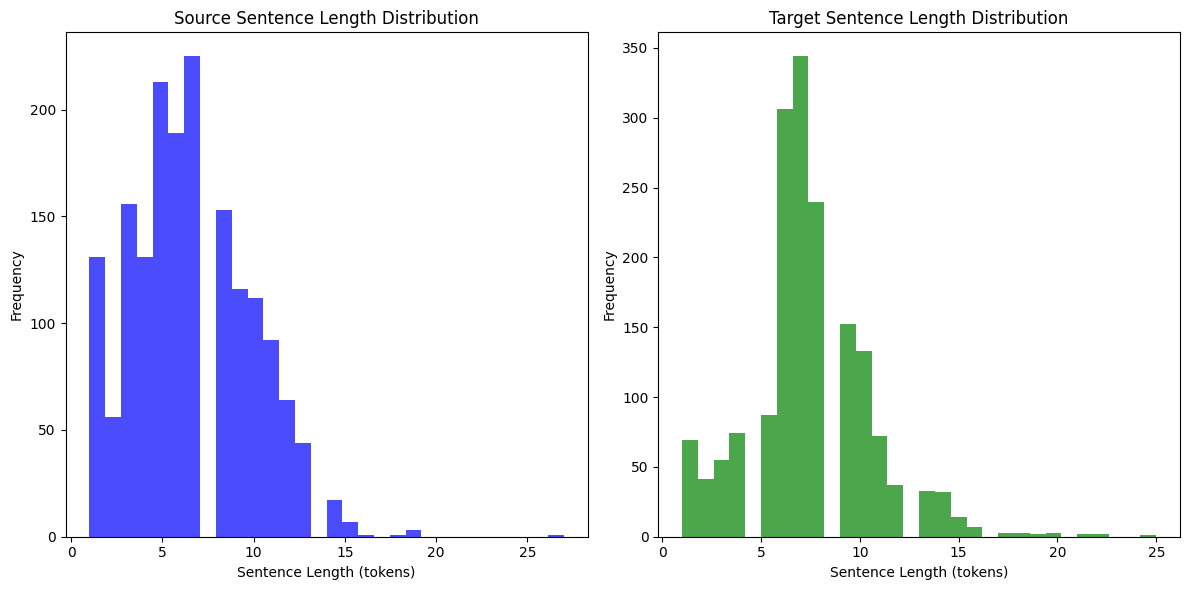

In [12]:
import matplotlib.pyplot as plt

# 각 문장의 토큰 길이를 KoBART 토크나이저로 계산 -> 서브워드 단어로 더 잘게 쪼개줌
df['source_len'] = df['gloss'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['target_len'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 히스토그램을 그려서 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['source_len'], bins=30, color='blue', alpha=0.7)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['target_len'], bins=30, color='green', alpha=0.7)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# 문장 길이 통계
source_stats = df['source_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
target_stats = df['target_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("Source Sentence Length Stats:\n", source_stats)
print("\nTarget Sentence Length Stats:\n", target_stats)

Source Sentence Length Stats:
 count    1712.000000
mean        6.547897
std         3.339199
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
90%        11.000000
95%        12.000000
99%        14.000000
max        27.000000
Name: source_len, dtype: float64

Target Sentence Length Stats:
 count    1712.000000
mean        7.393692
std         3.096788
min         1.000000
25%         6.000000
50%         7.000000
75%         9.000000
90%        11.000000
95%        13.000000
99%        16.000000
max        25.000000
Name: target_len, dtype: float64


## 2. 데이터 로더 생성

In [14]:
from torch.utils.data import Dataset, DataLoader

class GlossDataset(Dataset):
    def __init__(self, glosses, texts, tokenizer, max_length=13):
        self.glosses = glosses
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.glosses)

    def __getitem__(self, idx):
        gloss = self.glosses[idx]
        text = self.texts[idx]

        # 입력(글로스) 토큰화
        inputs = self.tokenizer(gloss, return_tensors="pt", max_length=self.max_length, padding="max_length", truncation=True)

        # 출력(텍스트) 토큰화
        labels = self.tokenizer(text, return_tensors="pt", max_length=self.max_length, padding="max_length", truncation=True)

        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        labels = labels.input_ids.squeeze()

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [15]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
train_glosses, val_glosses, train_texts, val_texts = train_test_split(df['gloss'].tolist(), df['text'].tolist(), test_size=0.2, random_state=42)
val_glosses, test_glosses, val_texts, test_texts = train_test_split(val_glosses, val_texts, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = GlossDataset(glosses=train_glosses, texts=train_texts, tokenizer=tokenizer)
val_dataset = GlossDataset(glosses=val_glosses, texts=val_texts, tokenizer=tokenizer)
test_dataset = GlossDataset(glosses=test_glosses, texts=test_texts, tokenizer=tokenizer)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [16]:
train_dataset[0]

{'input_ids': tensor([5824,  604,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]),
 'attention_mask': tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([5824,  604,  291,  222,  763,   15,    1,    0,    0,    0,    0,    0,
            0])}

## 3. 모델 준비

In [17]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저와 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)  # 학습률은 실험적으로 조정할 수 있음 1e-4, 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

# 학습률 스케줄러 설정
num_epochs = 100

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. KoT5 학습


In [18]:
# 체크포인트를 저장할 디렉토리 설정
import os

checkpoint_dir = './checkpoints_0823_base'
os.makedirs(checkpoint_dir, exist_ok=True)

In [21]:
import tqdm
from tqdm import tqdm
import sacrebleu
from nltk.translate.meteor_score import meteor_score

# 손실 값을 저장할 리스트 초기화
train_losses = []
val_losses = []
bleu_scores = []
meteor_scores = []

# 조기 종료 변수 설정
best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    print(f'\nStarting epoch {epoch+1}/{num_epochs}')

    # tqdm을 사용하여 배치 진행 상태 표시
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # 기울기 초기화

        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 데이터 전달
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝
        scheduler.step()  # 학습률 스케줄러 스텝

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # 훈련 손실 저장

    # Epoch 종료 후 검증 데이터셋에서 성능 평가
    model.eval()  # 평가 모드로 전환
    total_val_loss = 0
    predictions = []
    references = []

    with torch.no_grad():
        # tqdm을 사용하여 검증 배치 진행 상태 표시
        for batch in tqdm(val_dataloader, desc='Validation', unit='batch'):
            # 입력 데이터를 GPU로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # 예측 결과 디코딩
            decoded_preds = tokenizer.batch_decode(outputs.logits.argmax(dim=-1), skip_special_tokens=True)

            # 실제 레이블 디코딩
            decoded_labels = []
            for label in labels:
                label_ids = label[label != tokenizer.pad_token_id].tolist()
                decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                decoded_labels.append(decoded_label)

            # 예측 결과와 참조 번역 수집
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # 검증 손실 저장

    # BLEU 점수 계산
    bleu_score_value = sacrebleu.corpus_bleu(predictions, [references])
    bleu_scores.append(bleu_score_value.score)

    # METEOR 점수 계산 (참조 및 예측을 토큰화하여 전달)
    meteor_score_value = np.mean([meteor_score([ref.split()], pred.split()) for ref, pred in zip(references, predictions)])
    meteor_scores.append(meteor_score_value)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, BLEU: {bleu_score_value.score:.4f}, METEOR: {meteor_score_value:.4f}')

    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
        'val_loss': avg_val_loss,
        'bleu_score': bleu_score_value.score,
        'meteor_score': meteor_score_value
    }, checkpoint_path)

    print(f'Checkpoint saved to {checkpoint_path}')



Starting epoch 1/100


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.58batch/s]


Epoch 1/100, Loss: 11.1666, Validation Loss: 8.6516, BLEU: 2.1041, METEOR: 0.0465
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_1.pt

Starting epoch 2/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 18.54batch/s]


Epoch 2/100, Loss: 7.6945, Validation Loss: 4.8257, BLEU: 5.6665, METEOR: 0.0280
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_2.pt

Starting epoch 3/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.26batch/s]


Epoch 3/100, Loss: 3.6354, Validation Loss: 1.6268, BLEU: 22.6024, METEOR: 0.2250
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_3.pt

Starting epoch 4/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 20.30batch/s]


Epoch 4/100, Loss: 1.8031, Validation Loss: 1.0170, BLEU: 31.8712, METEOR: 0.2941
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_4.pt

Starting epoch 5/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.97batch/s]


Epoch 5/100, Loss: 1.2500, Validation Loss: 0.8747, BLEU: 34.0807, METEOR: 0.3242
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_5.pt

Starting epoch 6/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.67batch/s]


Epoch 6/100, Loss: 1.0303, Validation Loss: 0.7926, BLEU: 36.1064, METEOR: 0.3608
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_6.pt

Starting epoch 7/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.72batch/s]


Epoch 7/100, Loss: 0.8993, Validation Loss: 0.7410, BLEU: 39.9313, METEOR: 0.3998
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_7.pt

Starting epoch 8/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.69batch/s]


Epoch 8/100, Loss: 0.8213, Validation Loss: 0.7024, BLEU: 42.0452, METEOR: 0.4216
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_8.pt

Starting epoch 9/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.71batch/s]


Epoch 9/100, Loss: 0.7616, Validation Loss: 0.6568, BLEU: 43.1283, METEOR: 0.4326
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_9.pt

Starting epoch 10/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.71batch/s]


Epoch 10/100, Loss: 0.7027, Validation Loss: 0.6276, BLEU: 44.5617, METEOR: 0.4484
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_10.pt

Starting epoch 11/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.80batch/s]


Epoch 11/100, Loss: 0.6678, Validation Loss: 0.5962, BLEU: 44.9401, METEOR: 0.4571
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_11.pt

Starting epoch 12/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.53batch/s]


Epoch 12/100, Loss: 0.6173, Validation Loss: 0.5782, BLEU: 46.3827, METEOR: 0.4657
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_12.pt

Starting epoch 13/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.76batch/s]


Epoch 13/100, Loss: 0.5823, Validation Loss: 0.5584, BLEU: 46.7328, METEOR: 0.4693
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_13.pt

Starting epoch 14/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.77batch/s]


Epoch 14/100, Loss: 0.5480, Validation Loss: 0.5461, BLEU: 46.7784, METEOR: 0.4745
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_14.pt

Starting epoch 15/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.71batch/s]


Epoch 15/100, Loss: 0.5226, Validation Loss: 0.5310, BLEU: 48.4493, METEOR: 0.4803
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_15.pt

Starting epoch 16/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.52batch/s]


Epoch 16/100, Loss: 0.4990, Validation Loss: 0.5240, BLEU: 50.5350, METEOR: 0.4928
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_16.pt

Starting epoch 17/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.88batch/s]


Epoch 17/100, Loss: 0.4764, Validation Loss: 0.5192, BLEU: 51.5057, METEOR: 0.5005
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_17.pt

Starting epoch 18/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.74batch/s]


Epoch 18/100, Loss: 0.4486, Validation Loss: 0.5092, BLEU: 52.3486, METEOR: 0.5110
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_18.pt

Starting epoch 19/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.41batch/s]


Epoch 19/100, Loss: 0.4222, Validation Loss: 0.5007, BLEU: 52.7591, METEOR: 0.5141
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_19.pt

Starting epoch 20/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.34batch/s]


Epoch 20/100, Loss: 0.4090, Validation Loss: 0.4959, BLEU: 53.4981, METEOR: 0.5313
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_20.pt

Starting epoch 21/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.11batch/s]


Epoch 21/100, Loss: 0.3792, Validation Loss: 0.4945, BLEU: 53.5399, METEOR: 0.5245
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_21.pt

Starting epoch 22/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.63batch/s]


Epoch 22/100, Loss: 0.3627, Validation Loss: 0.4893, BLEU: 55.3910, METEOR: 0.5556
Checkpoint saved to ./checkpoints_0823_base/checkpoint_epoch_22.pt

Starting epoch 23/100


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.26batch/s]


Epoch 23/100, Loss: 0.3442, Validation Loss: 0.4889, BLEU: 56.6366, METEOR: 0.5736


KeyboardInterrupt: 

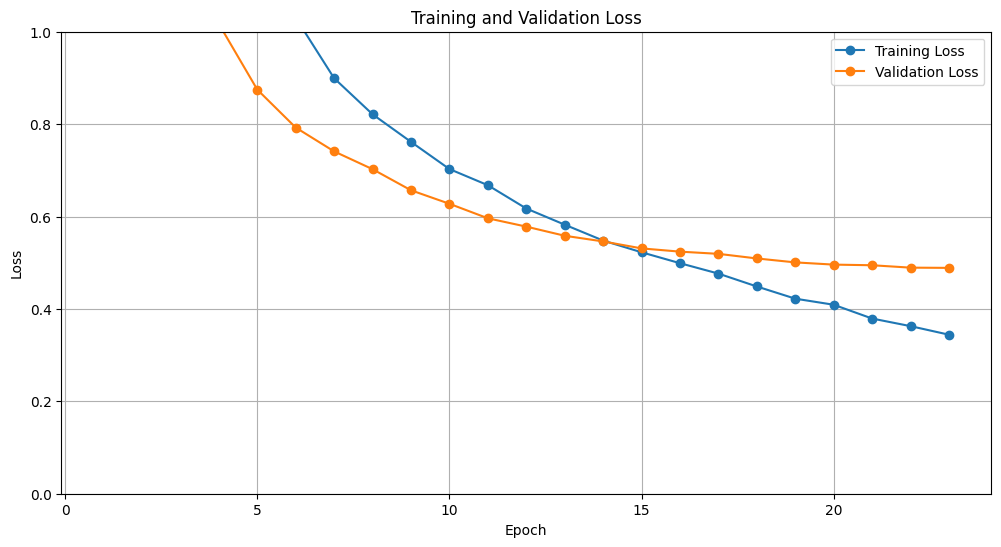

In [22]:
import matplotlib.pyplot as plt

# 손실 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim([0, 1])
plt.grid(True)
plt.show()


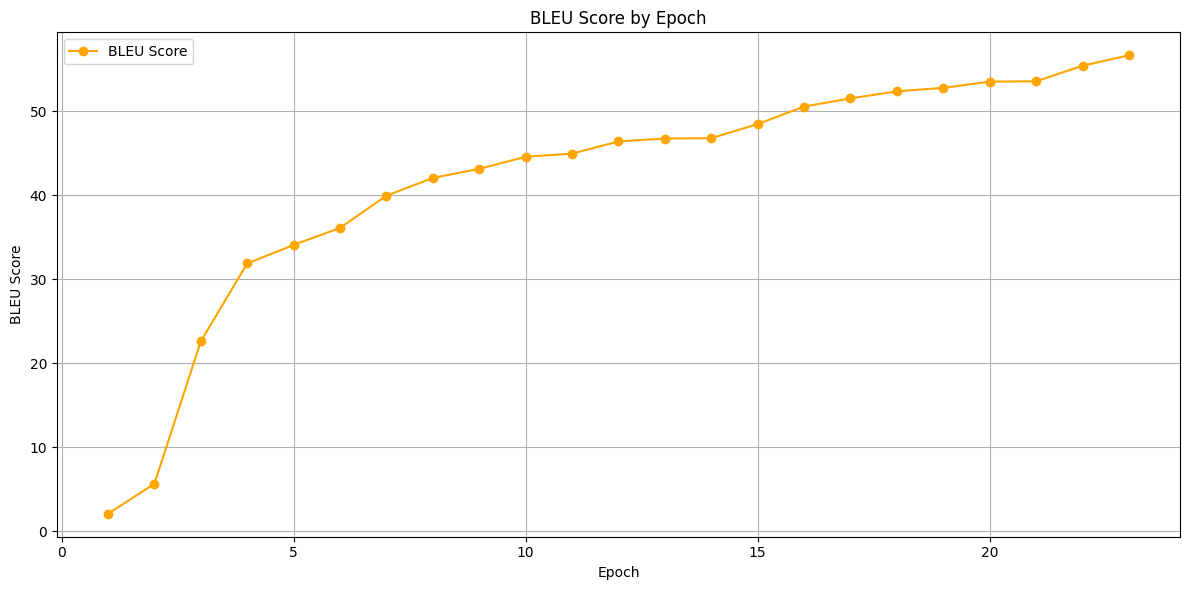

In [23]:
# BLEU 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, label='BLEU Score', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score by Epoch')
plt.legend()
plt.grid(True)

# 전체 시각화 출력
plt.tight_layout()
plt.show()

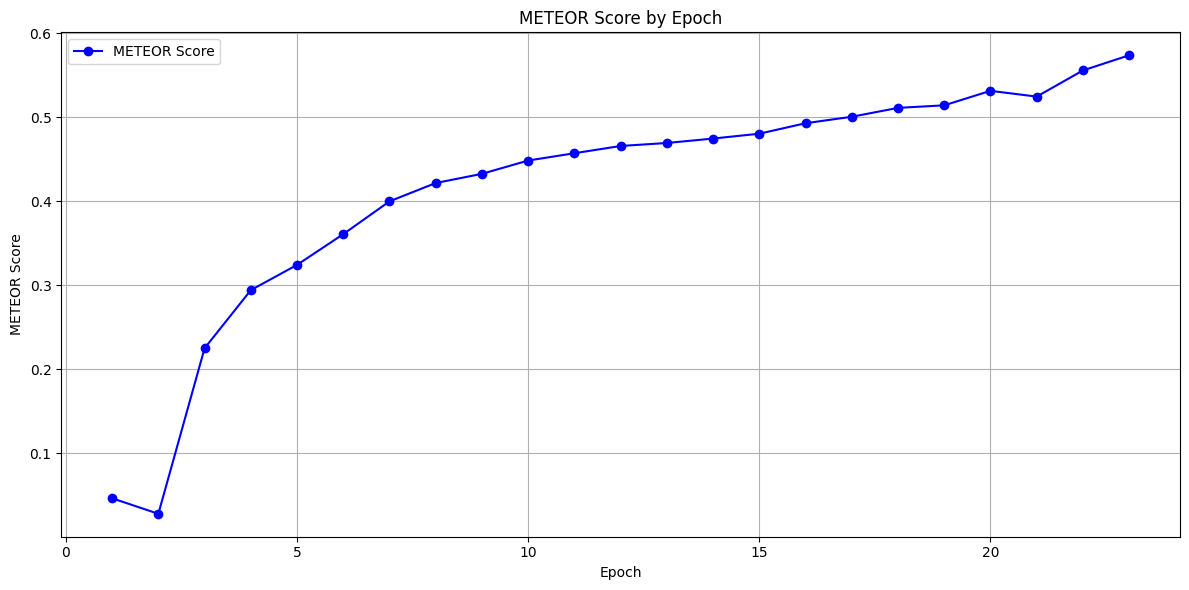

In [24]:
# Meteor 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(meteor_scores) + 1), meteor_scores, label='METEOR Score', marker='o', color='BLUE')
plt.xlabel('Epoch')
plt.ylabel('METEOR Score')
plt.title('METEOR Score by Epoch')
plt.legend()
plt.grid(True)

# 전체 시각화 출력
plt.tight_layout()
plt.show()

## 5. test

In [25]:
#train_losses
(np.argmin(val_losses)+1, np.argmax(bleu_scores)+1, np.argmax(meteor_scores)+1)
#

(23, 23, 23)

In [32]:
# 체크포인트 로드
checkpoint_path = '/content/checkpoints_0823_base/checkpoint_epoch_22.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
#!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
#!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
import torch
import sacrebleu
from tqdm import tqdm
import nltk
from nltk.translate.meteor_score import meteor_score

# 모델을 GPU로 이동
model = model.to(device)

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 참조 번역 수집
predictions = []
references = []
meteor_scores = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 데이터 전달
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=256,  # 적절한 max_length 설정
            length_penalty=2.0,  # 번역 길이 조절
            num_beams=4,  # 빔 서치의 수
            early_stopping=True
        )

        # 예측 결과 디코딩
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # 실제 레이블 디코딩
        decoded_labels = []
        for label in labels:
            label_ids = label[label != tokenizer.pad_token_id].tolist()
            if label_ids:
                try:
                    decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                except OverflowError:
                    decoded_label = "[UNK]"  # Unknown token으로 처리
                decoded_labels.append(decoded_label)
            else:
                decoded_labels.append('')  # 빈 문자열로 처리

        # 예측 결과와 참조 번역 수집
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        # METEOR 점수 계산 (토큰화된 형태로 변환)
        for pred, ref in zip(decoded_preds, decoded_labels):
            meteor_scores.append(meteor_score([ref.split()], pred.split()))

# BLEU 점수 계산
bleu_score = sacrebleu.corpus_bleu(predictions, [references])

# METEOR 점수 평균 계산
avg_meteor_score = sum(meteor_scores) / len(meteor_scores)

print(f'BLEU score: {bleu_score.score:.4f}')
print(f'METEOR score: {avg_meteor_score:.4f}')


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

BLEU score: 46.5040
METEOR score: 0.5032


In [ ]:
# 기본
import torch

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    for sentence in sentences:
        # 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        for output in output_ids:
            translation = tokenizer.decode(output, skip_special_tokens=True)
            translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
# test_sentences = ["날씨 덥다 화 난다.", "지금 바쁘다 미래 연락."]
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 마시다", '수영장 가다 놀다', '재미 있다 피곤하다 잠']

translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 너무 더워서 화가 난다', '목이 마르다', '수영장에 가서 놀다', '재미 있어서 졸려']


In [ ]:
# 테스트 문장
# test_sentences = ["날씨 덥다 화 난다.", "지금 바쁘다 미래 연락."]
test_sentences = ["어제 일찍 자다"]

translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['어제는 일찍 일어나서 잤다']


In [ ]:
# 앞 문장과 합성해서 뒷 문장 내용 추출

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []

    for i, sentence in enumerate(sentences):
        if i > 0:
            # 이전 번역된 문장을 참조하지 않고 현재 문장만 입력으로 사용
            combined_sentence = sentences[i-1] + " " + sentence
        else:
            combined_sentence = sentence

        # 토큰화 및 텐서 변환
        inputs = tokenizer(combined_sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "물 마시다 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 너무 더워서 화가 난다', '날씨가 너무 더워서 물이 마시고 싶어']
